In [1]:
import pandas as pd
import numpy as np

In [2]:
# for processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# for bag-of-words
from sklearn import feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

## for train test split
import imblearn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JYM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JYM\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\JYM\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
cfpb_df = pd.read_csv('../../data/CFPB with Duplicate Marked.csv')
print(cfpb_df.columns)
print(cfpb_df.shape)

C:\Users\JYM\AppData\Local\Temp/ipykernel_3924/889607879.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  cfpb_df = pd.read_csv('../../data/CFPB with Duplicate Marked.csv')


Index(['Unnamed: 0', 'Date received', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'Consumer complaint narrative', 'Company public response',
       'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID', 'narr_len',
       'days_to_today', 'dupi_id', 'dupi_len'],
      dtype='object')
(1300361, 23)


In [5]:
%%time
# Drop duplicates based on 'dupi_id' column
cfpb_df = cfpb_df.drop_duplicates(subset='dupi_id')
print(cfpb_df.shape)

(1106587, 23)
Wall time: 455 ms


### Some cleaning and normalizing while trying to keep some the context of data

our first try without any normalization did not yield good results, the accuracy was below 50% and the recal for debtcollection is very low

In [6]:
## our choices of stop words
lst_stopwords = nltk.corpus.stopwords.words('english')
#our choice of stemmer
stemm=nltk.stem.porter.PorterStemmer()
#our choice of lemmatizer
lemm=nltk.stem.wordnet.WordNetLemmatizer()


def nltk_text_normalizer(text):
    
    '''
    Preprocess a string using nltk tools.
    you need to import nltk
    download nltk.download('wordnet')
    and from nltk.stem import WordNetLemmatizer
    :parameter
        :param text: string - name of column containing text
        :param stemm: object - stemmer to be used like nltk.stem.porter.PorterStemmer()
        :param lemm: object - lemmatizer() to be used, like WordNetLemmatizer() 
        :param case_folding - whether text will be convert to lower case
        :param lst_stopwords - words to be moved
    :return
        cleaned text
    '''
    
    ## First we will clean up the XXXX maskings in the text created by CFPB
    text = re.sub(r'X{2,}', '', str(text).strip())
    
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', text)
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = text.lower().strip()
            
    ## Tokenize (convert from string to list)
    ## split is the simplest way
    # lst_text = text.split()
    ## here we use nltk tools to tokenize a text
    lst_text = word_tokenize(text)
    
    ## remove Stopwords
    # lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    ## Lemmatisation (convert the word into root word)
    lst_text = [lemm.lemmatize(word) for word in lst_text]
        
    ## Stemming (remove -ing, -ly, ...)
    ## This stemming parts works pretty bad, but is faster and simplified version of Lemmatization
    lst_text = [stemm.stem(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

def normalize_narr(df):
    df['Consumer complaint narrative'] = df['Consumer complaint narrative'].apply(nltk_text_normalizer)
    return df

In [7]:
%%time
cfpb_df = cfpb_df.groupby(['Product', 'Issue', 'State', 'ZIP code']).apply(func=normalize_narr)

KeyboardInterrupt: 

In [ ]:
cfpb_df.to_csv('clean_narr_tmp.csv', index=False)

In [ ]:
cfpb_df = pd.read_csv('clean_narr_tmp.csv')

In [ ]:
# split dataset train, dev, test
train_df, dev_df, test_df = np.split(cfpb_df.sample(len(cfpb_df), random_state = 42), 
                                     [int(len(cfpb_df)*0.75), int(len(cfpb_df)*0.9)])
train_df.to_csv('cfpb_train.csv', index=False)
test_df.to_csv('cfpb_test.csv', index=False)
dev_df.to_csv('cfpb_dev.csv', index=False)

In [4]:
train_df = pd.read_csv('cfpb_train.csv')

C:\Users\JYM\AppData\Local\Temp/ipykernel_36860/3254603939.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('cfpb_train.csv')


In [5]:
cfpb_df = train_df
cfpb_df['Consumer complaint narrative'].fillna('', inplace=True)
cfpb_df['Consumer complaint narrative'] = cfpb_df['Consumer complaint narrative'].astype(str)

### Round 1! Get all the 2-4-grams from the customer complaints.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase = False,ngram_range = (2,4))
vectorizer.fit(cfpb_df['Consumer complaint narrative'])
# This takes about 36GB RAM

TfidfVectorizer(lowercase=False, ngram_range=(2, 4))

In [7]:
# Extract the vocabulary and idf score
ngrams = vectorizer.get_feature_names_out()
# This takes about 31GB RAM

In [8]:
print(len(ngrams))

82767874


In [9]:
%%time
stop_words = set(stopwords.words('english'))
number_pattern = re.compile(r'^\d+|\d+$')  # match numbers at the start or end of a string
# regular expression to match repeating characters
repeating_chars_pattern = re.compile(r'^(.)\1*$')

filtered_vocab = {}

def clean_features(ngram):
    words = ngram.split()  # splits the n-gram into individual words
    # check if the n-gram starts/ends with a stop word or a number
    if (words[0] in stop_words or words[-1] in stop_words) or (number_pattern.match(words[0]) or number_pattern.match(words[-1]) or (repeating_chars_pattern.match(words[0]) or repeating_chars_pattern.match(words[-1]))):
        return False
    return True

ngrams_to_keep = [ngram for ngram in ngrams if clean_features(ngram)]

Wall time: 1min 3s


In [10]:
print(len(ngrams_to_keep))

32828019


### Round 2! Find proper document frequency thresholds
no new vocab is generated in this step

In [11]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt

# Creating a new vectorizer with your filtered vocabulary
filtered_vectorizer = TfidfVectorizer(lowercase=False, vocabulary=ngrams_to_keep, ngram_range=(2,4))

# Fitting the vectorizer and transforming the narratives
X = filtered_vectorizer.fit_transform(cfpb_df['Consumer complaint narrative'])

Wall time: 5min 2s


In [12]:
# Get the term frequencies
tf = np.sum(X, axis=0).A1

# Get the document frequencies
df = np.sum((X > 0), axis=0).A1

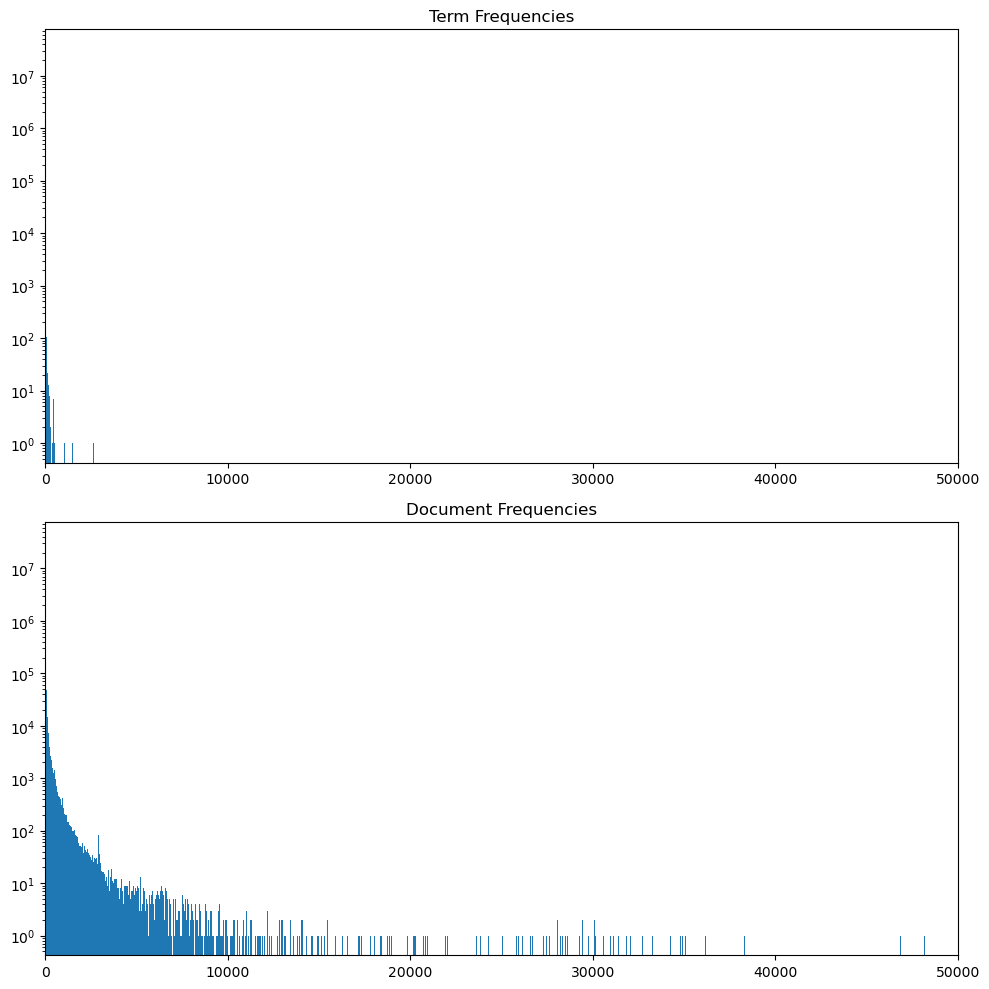

In [13]:
# Creating histograms for Term Frequencies and Document Frequencies
fig, axs = plt.subplots(2, figsize=(10, 10))

axs[0].hist(tf, bins=10000)
axs[0].set_title('Term Frequencies')
axs[0].set_yscale('log')  # Using log scale for better visualization
axs[0].set_xlim([0, 50000])  # Set x-axis limit to 0-5000


axs[1].hist(df, bins=10000)
axs[1].set_title('Document Frequencies')
axs[1].set_yscale('log')  # Using log scale for better visualization
axs[1].set_xlim([0, 50000])  # Set x-axis limit to 0-5000


plt.tight_layout()
plt.show()

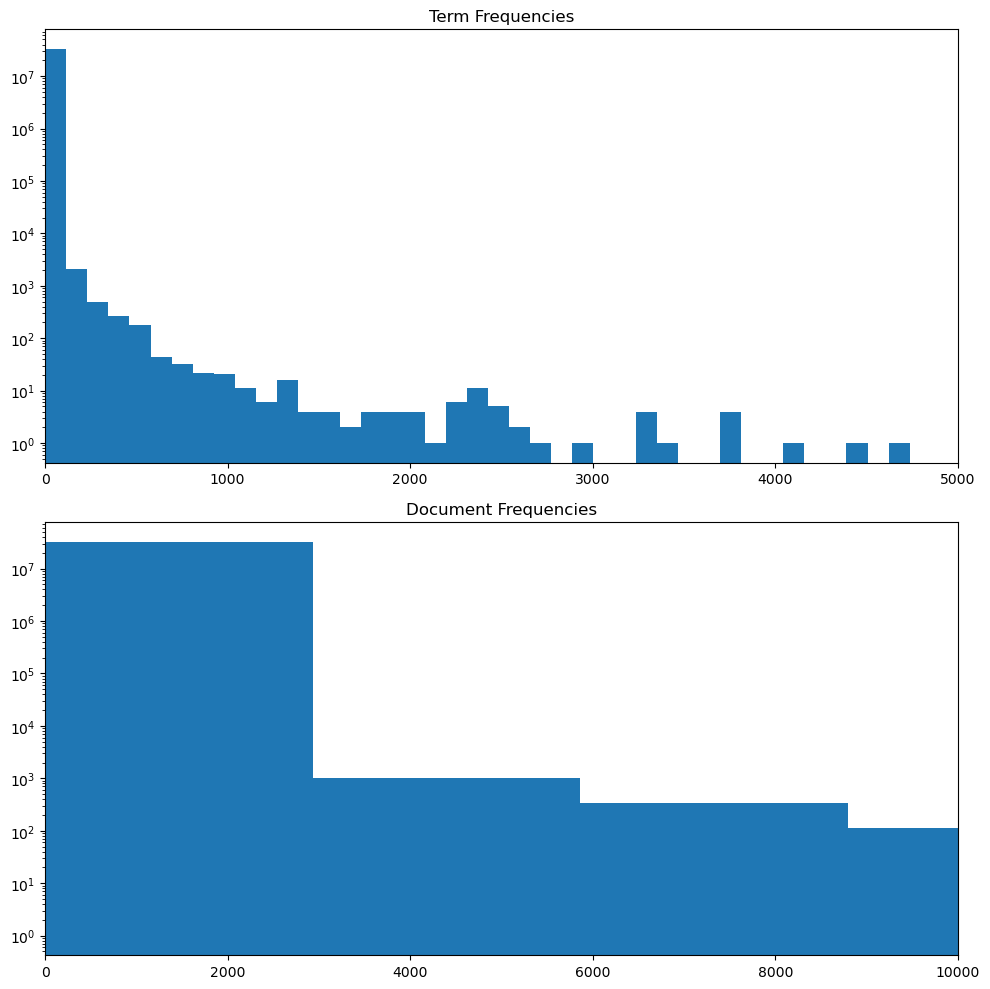

In [14]:
# Creating histograms for Term Frequencies and Document Frequencies
fig, axs = plt.subplots(2, figsize=(10, 10))

axs[0].hist(tf, bins=100)
axs[0].set_title('Term Frequencies')
axs[0].set_yscale('log')  # Using log scale for better visualization
axs[0].set_xlim([0, 5000])  # Set x-axis limit to 0-5000


axs[1].hist(df, bins=100)
axs[1].set_title('Document Frequencies')
axs[1].set_yscale('log')  # Using log scale for better visualization
axs[1].set_xlim([0, 10000])  # Set x-axis limit to 0-5000


plt.tight_layout()
plt.show()

We can see the historgram faltterned out after 800000, this suggest that even the most frequent tokens appeared 0.07 of the total complaints number, suggesting a max_df of 0.08. In this situation, even we set the max_df to 0.8, there won't be much feature can be captured. On the other hand, the histrogram shows a sharp drop after 2000, suggesting a good threshold to drop the rearer n-grams to be 1500 documents.

### Round 3! Further Reduce n-gram Features By through variance

In [15]:
%%time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt

# Creating a new vectorizer with your filtered vocabulary, the max_df is actually 0.08 by calculation
filtered_vectorizer = TfidfVectorizer(lowercase=False, vocabulary=ngrams_to_keep, ngram_range=(2,4), max_df=0.8, min_df=1500)

# Fitting the vectorizer and transforming the narratives
X = filtered_vectorizer.fit_transform(cfpb_df['Consumer complaint narrative'])

Wall time: 5min 9s


In [16]:
print(len(filtered_vectorizer.get_feature_names_out()))

32828019


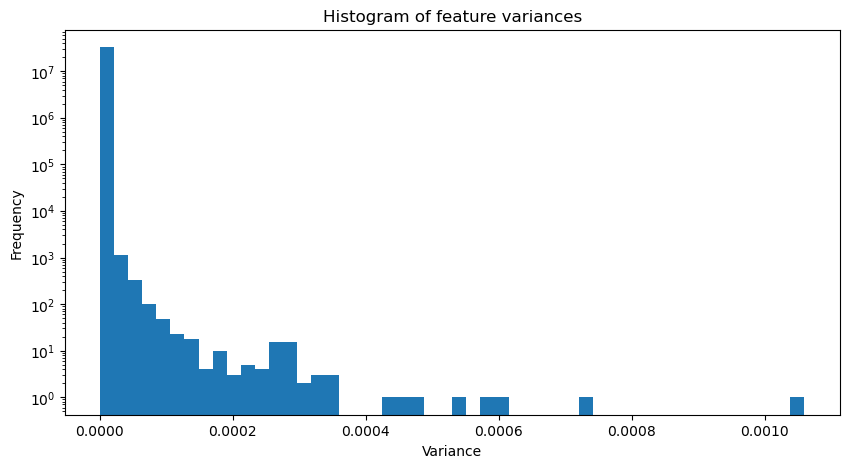

Wall time: 10.1 s


In [17]:
%%time
# Compute mean
means = np.array(X.mean(axis=0)).ravel()

# Compute variance
variances = np.array((X.multiply(X) - 2 * X.multiply(means)).mean(axis=0) + means**2).ravel()

# Plotting histogram of variances
plt.figure(figsize=(10,5))
plt.hist(variances, bins=50, log=True)
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.title('Histogram of feature variances')
plt.show()

In [18]:
# Define your threshold
threshold = 0.0000001# 0.00001 * (1 - 0.00001)

# Get all feature names
feature_names = filtered_vectorizer.get_feature_names_out()
print(len(feature_names))
# Filter the feature names based on your variance threshold
filtered_feature_names_1M = [feature for feature, var in zip(feature_names, variances) if var >= threshold]
print(len(filtered_feature_names_1M))

32828019
1141075


In [19]:
# Define your threshold
threshold = 0.00000019# 0.00001 * (1 - 0.00001)

# Filter the feature names based on your variance threshold
filtered_feature_names_500k = [feature for feature, var in zip(feature_names, variances) if var >= threshold]
print(len(filtered_feature_names_500k))

522919


In [26]:
# Define your threshold
threshold = 0.0000022# 0.00001 * (1 - 0.00001)

# Filter the feature names based on your variance threshold
filtered_feature_names_33k = [feature for feature, var in zip(feature_names, variances) if var >= threshold]
print(len(filtered_feature_names_33k))

30288


In [21]:
# Define your threshold
threshold = 0.000005# 0.00001 * (1 - 0.00001)

# Filter the feature names based on your variance threshold
filtered_feature_names_11k = [feature for feature, var in zip(feature_names, variances) if var >= threshold]
print(len(filtered_feature_names_11k))

11401


In [22]:
# Define your threshold
threshold = 0.00001# 0.00001 * (1 - 0.00001)

# Filter the feature names based on your variance threshold
filtered_feature_names_5k = [feature for feature, var in zip(feature_names, variances) if var >= threshold]
print(len(filtered_feature_names_5k))

4808


In [23]:
# %%time
# from sklearn.feature_selection import VarianceThreshold

# # Adjust VarianceThreshold
# variance_threshold = VarianceThreshold(threshold=(0.00001 * (1 - 0.00001)))

# # Apply VarianceThreshold
# X_var = variance_threshold.fit_transform(X)

# # Get the variances of all features
# variances = variance_threshold.variances_

# # Get the names of the remaining features after variance threshold
# feature_names_var = np.array(filtered_vectorizer.get_feature_names_out())[variance_threshold.get_support()]

# print(len(feature_names_var))

### Round 5! Get the TF-IDF vectorizers ready, we will create 5 according for different thresholds and computational power

In [24]:
import pickle

In [ ]:
# Creating a new vectorizer with your filtered vocabulary, the max_df is actually 0.08 by calculation
filtered_vectorizer = TfidfVectorizer(lowercase=False, vocabulary=filtered_feature_names_5k, ngram_range=(2,4), max_df=0.8, min_df=1500)
# Fitting the vectorizer and transforming the narratives
X = filtered_vectorizer.fit_transform(cfpb_df['Consumer complaint narrative'])
# Save the trained vectorizer
with open('tfidf_vectorizer_train_split_5k.pkl', 'wb') as f:
    pickle.dump(filtered_vectorizer, f)

In [ ]:
# Creating a new vectorizer with your filtered vocabulary, the max_df is actually 0.08 by calculation
filtered_vectorizer = TfidfVectorizer(lowercase=False, vocabulary=filtered_feature_names_11k, ngram_range=(2,4), max_df=0.8, min_df=1500)
# Fitting the vectorizer and transforming the narratives
X = filtered_vectorizer.fit_transform(cfpb_df['Consumer complaint narrative'])
# Save the trained vectorizer
with open('tfidf_vectorizer_train_split_11k.pkl', 'wb') as f:
    pickle.dump(filtered_vectorizer, f)

In [27]:
# Creating a new vectorizer with your filtered vocabulary, the max_df is actually 0.08 by calculation
filtered_vectorizer = TfidfVectorizer(lowercase=False, vocabulary=filtered_feature_names_33k, ngram_range=(2,4), max_df=0.8, min_df=1500)
# Fitting the vectorizer and transforming the narratives
X = filtered_vectorizer.fit_transform(cfpb_df['Consumer complaint narrative'])
# Save the trained vectorizer
with open('tfidf_vectorizer_train_split_33k.pkl', 'wb') as f:
    pickle.dump(filtered_vectorizer, f)

In [ ]:
# Creating a new vectorizer with your filtered vocabulary, the max_df is actually 0.08 by calculation
filtered_vectorizer = TfidfVectorizer(lowercase=False, vocabulary=filtered_feature_names_500k, ngram_range=(2,4), max_df=0.8, min_df=1500)
# Fitting the vectorizer and transforming the narratives
X = filtered_vectorizer.fit_transform(cfpb_df['Consumer complaint narrative'])
# Save the trained vectorizer
with open('tfidf_vectorizer_train_split_500k.pkl', 'wb') as f:
    pickle.dump(filtered_vectorizer, f)

In [ ]:
# Creating a new vectorizer with your filtered vocabulary, the max_df is actually 0.08 by calculation
filtered_vectorizer = TfidfVectorizer(lowercase=False, vocabulary=filtered_feature_names_1M, ngram_range=(2,4), max_df=0.8, min_df=1500)
# Fitting the vectorizer and transforming the narratives
X = filtered_vectorizer.fit_transform(cfpb_df['Consumer complaint narrative'])
# Save the trained vectorizer
with open('tfidf_vectorizer_train_split_1M.pkl', 'wb') as f:
    pickle.dump(filtered_vectorizer, f)

In [ ]:
# Load the trained vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)